# XGMix Demo

This notebook takes you through the process of using the tool for local ancestry predictions using a pre-trained model and then gives an example of how to analyze the results.

### Loading packages

In [1]:
import numpy as np
import os
import pandas as pd
from scipy import stats
from sklearn.metrics import confusion_matrix

# local functions
from postprocess import get_samples_from_msp_df
from visualization import plot_cm, plot_chm

## Using tool for prediction

Here we use the command line interface to make predictions and write the results to the file *demo.msp.txv*. All the files are stored inside the *demo_data* folder **except for the query file** which can be downloaded from ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/.

The pre-trained model is the *chm_22.pkl.gz* model from [XGMix-models/build37/missing_0](https://github.com/AI-sandbox/XGMix-models/tree/master/build37/missing_0).

In [3]:
# Arguments
query_file       = "./demo_data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
genetic_map_file = "./demo_data/allchrs.b37.gmap"
output_basename  = "./demo_data/demo"
chm              = "22"
phase            = "False"
path_to_model    = "./demo_data/XGMix_chm22_missing0.pkl.gz" 

# defining and executing the command
run_cmd =  "python3 XGMIX.py"
cmd = " ".join([run_cmd, query_file, genetic_map_file, output_basename, chm, phase, path_to_model])
print("Running in command line: \n\t", cmd)
os.system(cmd)

Running in command line: 
	 python3 XGMIX.py ./demo_data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz ./demo_data/allchrs.b37.gmap ./demo_data/demo 22 False ./demo_data/XGMix_chm22_missing0.pkl.gz


## Analyzing results

### Reading from the ouput

Here we read the results from the output file into a dataframe

In [6]:
# read the output file into a dataframe
output_file = output_basename+".msp.tsv"
msp_df = pd.read_csv(output_file, sep="\t", skiprows=[0])
msp_df

,#chm,spos,epos,sgpos,egpos,n snps,HG00096.0,HG00096.1,HG00097.0,HG00097.1,...,NA21137.0,NA21137.1,NA21141.0,NA21141.1,NA21142.0,NA21142.1,NA21143.0,NA21143.1,NA21144.0,NA21144.1
0,22,16854565,16938410,1.58688,1.69202,15410,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
1,22,16938658,17078370,1.69205,1.78805,3398,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
2,22,17078573,17218640,1.78841,1.99438,3524,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
3,22,17218745,17348770,1.99440,2.22692,3035,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
4,22,17348771,17457426,2.22692,2.61159,3256,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,22,50688236,50792508,73.37332,73.45642,3746,3,3,3,6,...,6,6,6,6,6,6,6,6,6,6
313,22,50792509,50894104,73.45642,73.53175,3657,7,3,3,3,...,6,6,6,6,6,6,6,6,6,6
314,22,50894372,50980910,73.53192,73.80571,3830,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
315,22,50980917,51078251,73.80572,73.92507,3199,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6


## Measuring performance

Here we predict **single ancestry** for each individual by creatoing a dataframe containing only one label prediction for each individual. We do so simply by taking the mode of the local predictions for each individual.

In [7]:
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)

# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]

# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
pred_df

,Sample,Prediction
0,HG00096,EUR
1,HG00097,EUR
2,HG00099,EUR
3,HG00100,EUR
4,HG00101,EUR
...,...,...
2499,NA21137,SAS
2500,NA21141,SAS
2501,NA21142,SAS
2502,NA21143,SAS


We can read the true labels from the sample map file and add them to the dataframe.

In [8]:
# adding the true labels
sample_map_file = "./demo_data/demo_sample_map.txt" # find the true labels in the sample map file
sample_map_df = pd.read_csv(sample_map_file, sep="\t")
true_labels_df = sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
pred_df

,Sample,Prediction,Population
0,HG00096,EUR,EUR
1,HG00097,EUR,EUR
2,HG00099,EUR,EUR
3,HG00100,EUR,EUR
4,HG00101,EUR,EUR
...,...,...,...
1215,NA20822,EUR,EUR
1216,NA20826,EUR,EUR
1217,NA20827,EUR,EUR
1218,NA20828,EUR,EUR


And then compare the predictions with the true labels

In [9]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")

Accuracy for single ancestry: 100.0%


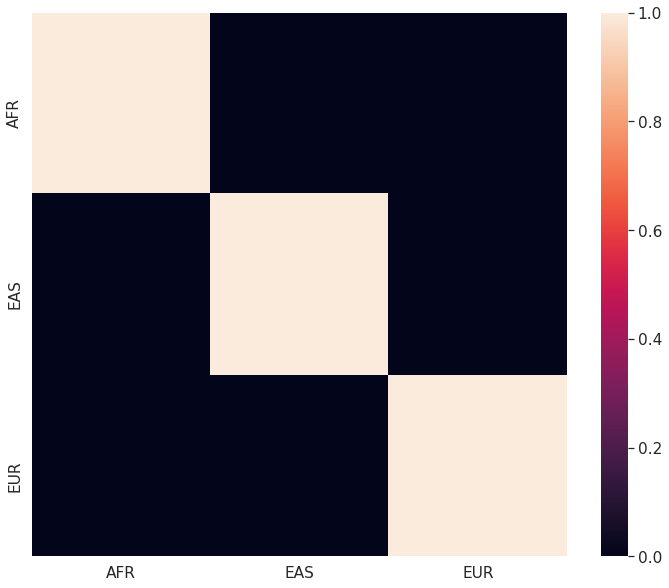

In [11]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
cm_plot.figure.savefig('./demo_data/imgs/single_ancestry_confusion_matrix.png')

## Plotting the prediction

We can use the results to plot the predictions along the chromosome. Here is an example of how to use [Tagore](https://pypi.org/project/tagore/#usage) for that purpose. Here we visualize one individual and only for chromosome 22. See **plot_chm** from *visualization.py* for more details of how to to that.

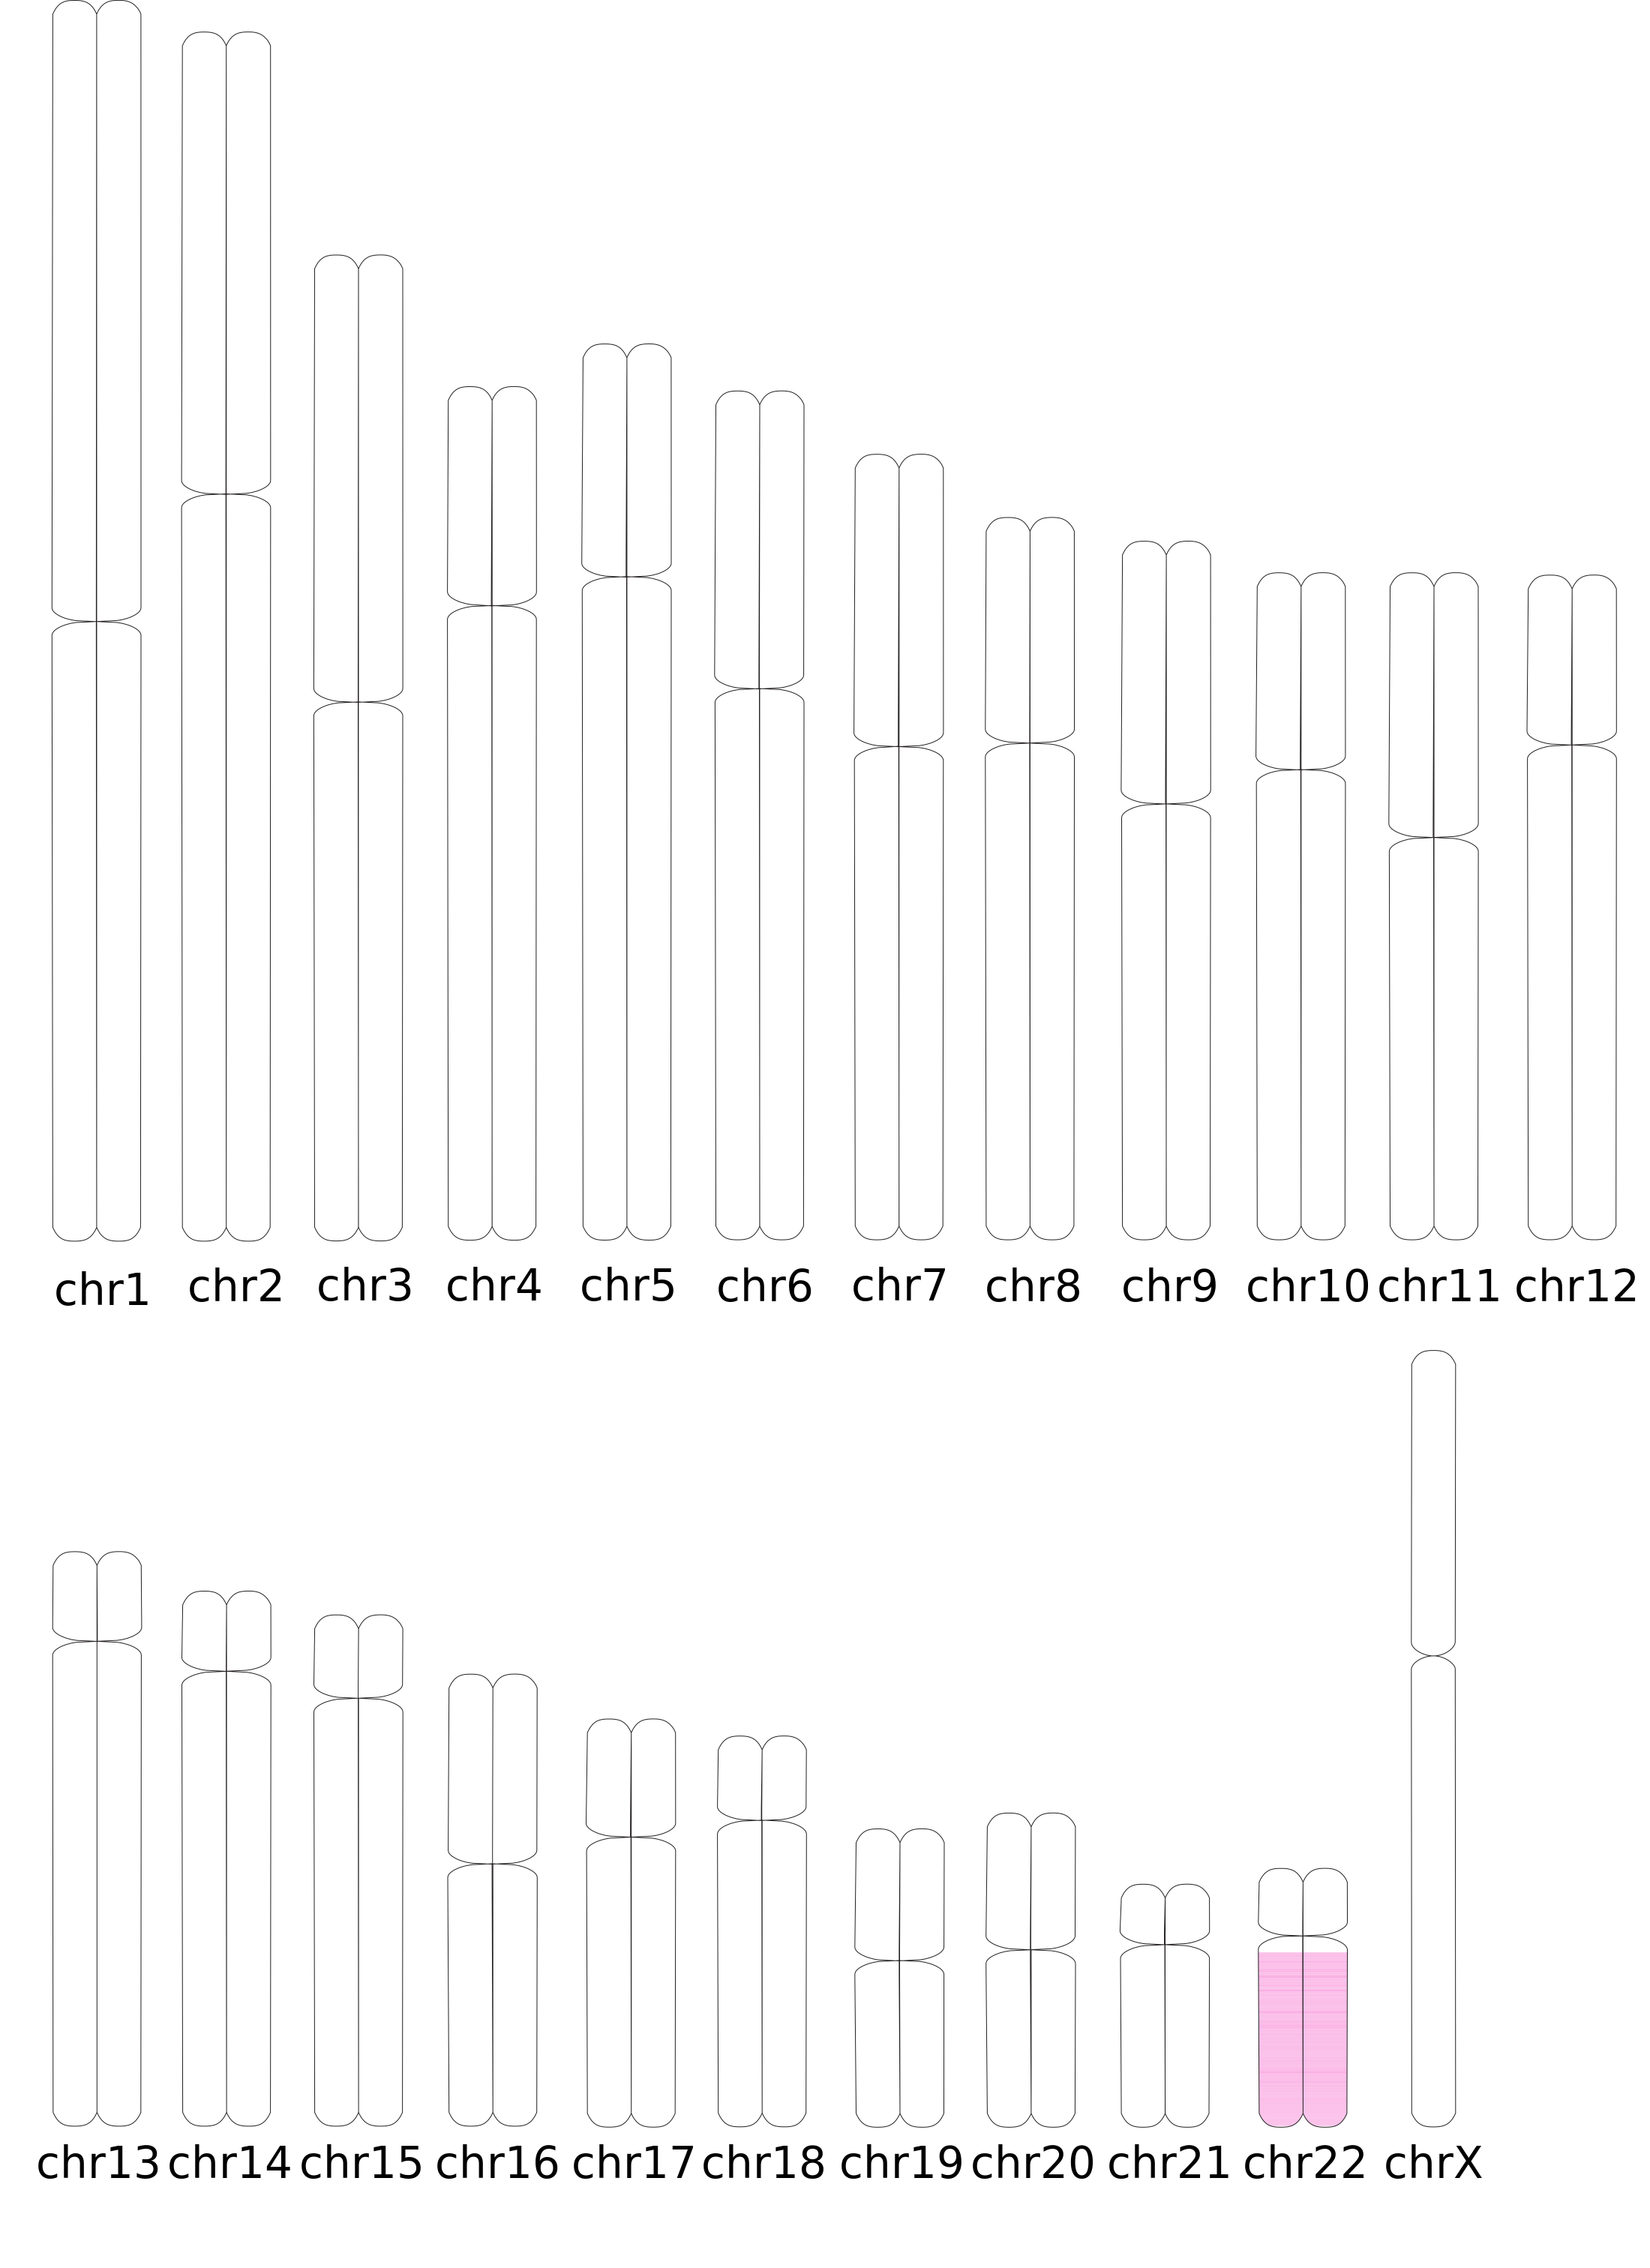

In [12]:
from IPython.display import Image

sample_id = "NA21141" # looking at just one random sample
img_name = "./demo_data/imgs/chm_img"
plot_chm(sample_id, msp_df, img_name)
Image(filename=img_name+".png")